# Warum ist es wichtig Elon Musk Tweets zu generieren?
Elon Musk ist seit 2020 der reichste Mann der Welt. Zusätzlich ist er eine der einflussreichsten Personen auf der Plattform und baut diesen Einfluss damit aus, dass der seit 2022 der größte Anteilseigner der Plattform ist. Bei den Theman Unternehmensanteile, Elon Musk und Twitter wird es auch abseits von Elon Musks persönlicher Finanzlage interessant. Musk ist bekannt dafür, in den letzten Jahren mit seinen Tweets Aktienkurse beeinflusst zu haben. Er hat beispielsweise 2018 getwittert, dass er Tesla bei einem Aktienpreis von $420 wieder zu einem privaten, nicht gehandelten, Unternehmen machen würde. Dadurch stieg der Preis für die Aktie in den folgenden Tagen signifikant an [Vgl. SEC 2018](https://www.sec.gov/news/press-release/2018-219)
Wer finanzielle Interessen hat, könnte sich davon ausgehen damit beschäftigen, ein System zu entwickeln, das anhand von Elon Musks Meinung Aktien und Optionen kauft.
Wer finanzielle Interessen hat, sollte sich aber vielleicht auch nicht mit Elon Musks Tweets beschäftigen und denken, dass er anhand dessen der nächste Warren Buffet wird, sondern arbeiten. Viel interessanter wäre es doch eigene Tweets zu generieren. Einen Wert für die Gesellschaft hat das nicht. Damit lässt sich dennoch eine interessante Beobachtung machen. Textinhalte bei Twitter sind auf 240 Zeichen begrenzt. Komplexe Zusammenhänge mit verschiedenen Aussagen in einzelnen Tweets sind dadurch nur begrenzt möglich. Die meisten Sprachmodelle haben auch genau damit ein Problem, lange zusammenhängende Texte zu generieren in denen verschiedene Aussagen koherent sind.
Die Idee Tweets mit einem Sprachmodell zu generieren ist also eigentlich sehr naheliegend und dies auch nicht der erste Ansatz. Diese fokussieren sich aber alle auf Twitter im Allgemeinen und nicht spezifisch auf das Profil eines Nutzers oder eine Nutzerin. Das Interessante an einem einzelnen Profil, ist dass die Sprache und die Gedanken eines einzelnen Menschen nachgestellt werden und nicht einer ganzen Gruppe. Genau ein Mensch nicht wie alle Menschen auf Twitter spricht, soll das Model auch nicht lernen wie alle Menschen zu sprechen, sondern eben nur wie ein Mensch zu sprechen.
### Elon Musks Twitter Profil
![Elon Musks Twitter Profil](elonmusk_twitter.png)

In [1]:
import keras
import keras_tuner.engine.hyperparameters
import re

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
import torch
import datasets
from transformers import DefaultDataCollator, pipeline, AutoTokenizer, AutoModelForCausalLM, TFGPT2LMHeadModel, AdamWeightDecay, TFAutoModelForCausalLM
from rake_nltk import Rake
import nltk
from matplotlib import pyplot as plt
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ole\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ole\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Prüfen der Hardwarebeschleunigung
tf.debugging.set_log_device_placement(True)

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
tf.test.gpu_device_name()
#tf.config.experimental.set_virtual_device_configuration(gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


'/device:GPU:0'

## Daten vorbereiten

Zur Datenbeschaffung lässt sich theoretisch die API von Twitter nutzen, allerdings gibt es einen [Kaggle-Datensatz](https://www.kaggle.com/datasets/ayhmrba/elon-musk-tweets-2010-2021), in dem die Tweets der API bereits aufbereitet sind. Der Datensatz enthält zweets von 2010 bis 2022 in einzelnen Dateien. Alle dateien werden eingelesen und in einen DataFrame zusammengefasst.

In [81]:
tweets_from_years = {}

In [82]:
for i in os.listdir('musktweets'):
    year = i.rstrip('.csv')
    if i == '2021.csv' or i == '2022.csv':
        tweets_from_years[year] = pd.read_csv('musktweets/'+i)
    else:
        tweets_from_years[year] = pd.read_csv('musktweets/'+i, index_col='index')

Die Tabellen ab 2020 haben ein leicht verändertes Schema und müssen an die anderen angepasst werden. Außerdem werden nur bestimmte Felder zu weiteren Arbeit genutzt und die relativ häufigen Duplikate im Datensatz entfernt. Insgesamt sind das nur kosmetische Anpassungen, zur leichteren Arbeit mit dem Datensatz.

In [83]:
for year in tweets_from_years:
    if year == '2022' or year == '2021' or year == '2020':
        tweets_from_years[year].rename(columns={'likes_count':'nlikes'}, inplace=True)
        print(tweets_from_years[year].columns)

Index(['id', 'conversation_id', 'created_at', 'date', 'timezone', 'place',
       'tweet', 'language', 'hashtags', 'cashtags', 'user_id', 'user_id_str',
       'username', 'name', 'day', 'hour', 'link', 'urls', 'photos', 'video',
       'thumbnail', 'retweet', 'nlikes', 'nreplies', 'nretweets', 'quote_url',
       'search', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'],
      dtype='object')
Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'language', 'mentions',
       'urls', 'photos', 'replies_count', 'retweets_count', 'nlikes',
       'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'],
      dtype='object')
Index(['id', 'conver

In [84]:
tweets_from_years['2021']

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1476662222617251846,1476620230692679680,2021-12-31 01:11:23 Arabian Standard Time,2021-12-31,01:11:23,400,44196397,elonmusk,Elon Musk,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'roshanpateI', 'name': 'Rosha...",NaN,NaN,NaN,NaN
1,1476656306610216960,1476644467578859528,2021-12-31 00:47:53 Arabian Standard Time,2021-12-31,00:47:53,400,44196397,elonmusk,Elon Musk,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'tesla_raj', 'name': 'Tesla R...",NaN,NaN,NaN,NaN
2,1476651519986614281,1476252898115964928,2021-12-31 00:28:51 Arabian Standard Time,2021-12-31,00:28:51,400,44196397,elonmusk,Elon Musk,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'CSmithson80', 'name': 'Chris...",NaN,NaN,NaN,NaN
3,1476619907076923398,1476252898115964928,2021-12-30 22:23:14 Arabian Standard Time,2021-12-30,22:23:14,400,44196397,elonmusk,Elon Musk,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'BLKMDL3', 'name': 'Zack', 'i...",NaN,NaN,NaN,NaN
4,1476618021024190474,1476252898115964928,2021-12-30 22:15:45 Arabian Standard Time,2021-12-30,22:15:45,400,44196397,elonmusk,Elon Musk,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'mims', 'name': 'Christopher ...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3110,1345384139969552389,1345382294966571008,2021-01-02 18:59:09 Arabian Standard Time,2021-01-02,18:59:09,400,44196397,elonmusk,Elon Musk,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'flcnhvy', 'name': 'Viv ✶', '...",NaN,NaN,NaN,NaN
3111,1345382294966571008,1345382294966571008,2021-01-02 18:51:49 Arabian Standard Time,2021-01-02,18:51:49,400,44196397,elonmusk,Elon Musk,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3112,1345344958710992897,1345334831719337984,2021-01-02 16:23:28 Arabian Standard Time,2021-01-02,16:23:28,400,44196397,elonmusk,Elon Musk,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'newscientist', 'name': 'New ...",NaN,NaN,NaN,NaN
3113,1345208391958888448,1344675033231237120,2021-01-02 07:20:48 Arabian Standard Time,2021-01-02,07:20:48,400,44196397,elonmusk,Elon Musk,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'comma_ai', 'name': 'comma', ...",NaN,NaN,NaN,NaN


In [85]:
for year in tweets_from_years:
    tweets_from_years[year] = tweets_from_years[year][['nlikes','date', 'link','photos','reply_to','retweet','source','tweet','video']]
tweets_from_all_years = pd.concat([tweets_from_years[year] for year in tweets_from_years.keys()])
tweets_from_all_years = tweets_from_all_years.reset_index()
tweets_from_all_years

,index,nlikes,date,link,photos,reply_to,retweet,source,tweet,video
0,0,4652,2010-06-04 18:31:57,https://twitter.com/elonmusk/status/15434727182,[],[],False,NaN,"Please ignore prior tweets, as that was someon...",0
1,0,12,2011-12-28 22:27:08,https://twitter.com/elonmusk/status/1521536376...,[],[],False,NaN,@TheOnion So true :),0
2,1,39,2011-12-27 23:38:55,https://twitter.com/elonmusk/status/1518093150...,[],[],False,NaN,If you ever wanted to know the *real* truth ab...,0
3,2,155,2011-12-26 16:29:50,https://twitter.com/elonmusk/status/1513389393...,['https://pbs.twimg.com/media/Ahmp9qtCAAAYPDX....,[],False,NaN,Walked around a neighborhood recently rebuilt ...,1
4,3,158,2011-12-26 16:23:04,https://twitter.com/elonmusk/status/1513372374...,['https://pbs.twimg.com/media/AhmoamaCQAANvSt....,[],False,NaN,"It was Xmas, so we brought presents for the ki...",1
...,...,...,...,...,...,...,...,...,...,...
34873,1023,473530,2022-01-03,https://twitter.com/elonmusk/status/1477775713...,['https://pbs.twimg.com/media/FIIdLYoXoAEd2j_....,[],False,NaN,https://t.co/LA9hPzVlGx,1
34874,1024,320201,2022-01-02,https://twitter.com/elonmusk/status/1477706142...,[],[],False,NaN,Let’s make the roaring 20’s happen!,0
34875,1025,66405,2022-01-02,https://twitter.com/elonmusk/status/1477700424...,[],[],False,NaN,Great work by Tesla team worldwide!,0
34876,1026,45704,2022-01-01,https://twitter.com/elonmusk/status/1477096955...,[],"[{'screen_name': 'BLKMDL3', 'name': 'Zack', 'i...",False,NaN,@BLKMDL3 @Tesla 🔥,0


In [86]:
# ein paar Typconvertierungen
tweets_from_all_years['date'] = tweets_from_all_years['date'].astype('datetime64')

In [89]:
tweets_from_all_years = tweets_from_all_years.drop_duplicates(subset='tweet')

In den 15219 Tweets gibt es 10329 Antworten auf Tweets von anderen NutzerInnen. In der Wortwahl sind Antworten aber anders als eigenständige Tweets, weil Menschen ihre Sprache unterbewusst an die Sprache der anderen Menschen anpasst. Ohne den Kontext des ursprünglichen Tweet, ergibt ein Tweet außerdem inhaltlich auch nur wenig Sinn. Die automatische Generierung von Antworten wäre aber ein interessantes separates Projekt. In diesem Projekt werden aber nur eigenständige Tweets generiert, weshalb Tweets, die Antworten auf andere Tweets sind entfernt werden. In diesem Punkt unterscheidet sich das Projekt auch von einem anderen Projekt mit diesem Datensatz, in dem Tweets generiert wurden. In diesem Projekt waren auch antworten enthalten, weshalb primär fiktive Antworten auf andere Nutzer generiert werden. Es bleiben also 4890 Tweets für das Modell.

In [92]:
tweets_from_all_years = tweets_from_all_years[(tweets_from_all_years['reply_to']=='[]') & (tweets_from_all_years['retweet']==False)]

In [94]:
tweets_from_all_years[(tweets_from_all_years['retweet']!=False)].shape

(0, 10)

Für das Training werden außerdem Links durch einen Link Tag 'link' ersetzt, weil mit einem Modell natürlich keine echten Links generiert werden können.

In [95]:
url_re = re.compile(r"https?:\/\/\S*")
tweets_from_all_years['tweet']=tweets_from_all_years.apply(lambda x: url_re.sub('<link>',x['tweet'] if x['video'] == 0 else url_re.sub('<image>',x['tweet'])), axis=1)

In [99]:
tweets_from_all_years.sample(n=10)

,index,nlikes,date,link,photos,reply_to,retweet,source,tweet,video
3776,522,144,2016-04-30 01:14:50,https://twitter.com/elonmusk/status/7262182181...,[],[],False,NaN,@phillipcjackson turns out it doesn't need sec...,0
11849,1143,114300,2019-07-27 18:15:32,https://twitter.com/elonmusk/status/1155179932...,[],[],False,NaN,Ability to stream YouTube &amp; Netflix when c...,0
12459,1753,18065,2019-05-12 01:54:33,https://twitter.com/elonmusk/status/1127391581...,[],[],False,NaN,Much will likely go wrong on 1st mission. Also...,0
9917,1496,22488,2018-06-10 06:33:43,https://twitter.com/elonmusk/status/1005699514...,[],[],False,NaN,This is why I’m not impressed when reporters w...,0
1150,72,509,2014-08-03 19:11:50,https://twitter.com/elonmusk/status/4960105723...,[],[],False,NaN,"While on the subject of AI risk, Our Final Inv...",0
201,173,21,2012-04-30 20:10:22,https://twitter.com/elonmusk/status/1970553142...,[],[],False,NaN,T minus five minutes to flame,0
33939,89,205929,2022-02-23 00:00:00,https://twitter.com/elonmusk/status/1496252264...,['https://pbs.twimg.com/media/FMPBgHWWUAoro-w....,[],False,NaN,<image>,1
21311,2293,102318,2020-04-30 17:54:59,https://twitter.com/elonmusk/status/1255918585...,[],[],False,NaN,Classifying all deaths as corona even if coron...,0
31340,605,48501,2021-11-03 00:00:00,https://twitter.com/elonmusk/status/1455980193...,[],[],False,NaN,And Mars <link>,0
33332,2597,99495,2021-03-12 00:00:00,https://twitter.com/elonmusk/status/1370449655...,[],[],False,NaN,Both do mining &amp; use blocks &amp; chains,0


## Datenanalyse

Bevor Text generiert wird, ist es interessant sich einmal anzusehen, wie der Datensatz aufgebaut ist. Bei strukturierten und numerischen Daten gibt es dafür klare Möglichkeiten, die sich etabliert haben, wie etwa sich mit den Durchschnitten und Quantilen zu beschäftigen. Im Fall von Text ist das aber nicht direkt möglich und auch nicht wirklich nötig, weil es, wie später beschrieben nur wenig direkte Evaluierung gibt. Es ist aber wichtig ein Gefühl für den Datensatz zu erhalten um zu verstehen, ob die Generierungen gut oder schwach sind. Zuerst lässt sich die Herkunft der Daten bestimmen, aus welchem Jahr sie kommen. Wie zu erwarten ist hat Elon Musk mit voranschreitender Zeit mehr Tweets veröffentlicht. Der Datensatz reicht nur bis März 2022, weshalb es für das Jahr 2022 deutlich weniger Tweets sind, als im Juli 2022 zu erwarten wäre. 2019 war das aktivste Jahr von Elon Musk von Elon Musk. 2020 war er dann vermutlich damit beschäftigt sich über das erste Jahr zu freuen, in dem sein Unternehmen Tesla einen Gewinn abgeworfen hat und er twitterte entsprechend weniger.

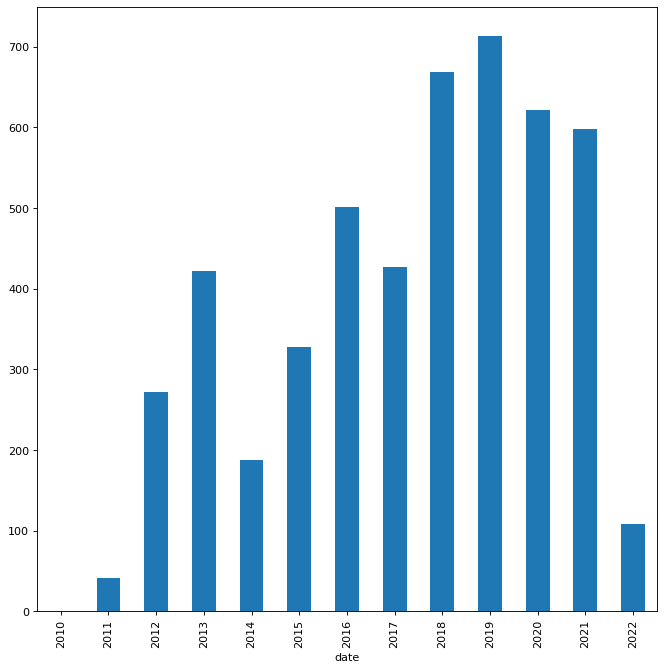

In [15]:
plt.figure(figsize=(10,10), dpi=80)
tweets_from_all_years.groupby(pd.Grouper(key = 'date',freq='Y')).size().plot(kind='bar')
plt.xticks(range(13),['2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020', '2021','2022'])
plt.show()

Zur Analyse des Textes der Tweets lässt sich ein tool wie Rake verwenden. Rake extrahiert die wichtigsten Keywords aus Texten. Dabei wird zuerst eine Stopwordliste angewendet, also eine Liste mit Wörtern die ignoriert werden sollen wie 'ist' oder 'das', weil sie sehr oft vorkommen aber nicht relevant für den Inhalt sind. Danach verwendet Rake verschiedene Methoden um die Wichtigkeit eines Wortes festzustellen, indem zum Beispiel die Co-Occurences mit anderen wichtigen Worten festgestellt wird.

In [17]:
tweet_buzzwords = Rake(max_length=3)
tweet_buzzwords.extract_keywords_from_sentences(tweets_from_all_years['tweet'].to_list())
tweet_buzzwords.get_ranked_phrases_with_scores()[:10]

[(9.0, '🖤🖤🖤🖤 🚘🚘🚘🚘 🖤🖤🖤🖤'),
 (9.0, '♥️♥️🇮🇸🇮🇸 ísland 🇮🇸🇮🇸♥️♥️'),
 (9.0, 'vigorously opposed subpoena'),
 (9.0, 'tcp packet walks'),
 (9.0, 'tallakt various forms'),
 (9.0, 'spinal cord transplant'),
 (9.0, 'spiked choker machined'),
 (9.0, 'some1gg transpiration cooling'),
 (9.0, 'siberian permafrost melting'),
 (9.0, 'shortseller enrichment commission')]

Die Ergebnisse der Keyword Extraktion sind allerdings nicht sehr aussagegräftig, wenn davon abgesehen wird, dass Musk scheinbar eine große Liebe für Island hat. Das ergibt aber auch durchaus Sinn, wenn bedacht wird, dass Rake eigentlich für größere Texte entwickelt wurde. [(Vgl. Rose 2010 et. al.)](https://www.researchgate.net/publication/227988510_Automatic_Keyword_Extraction_from_Individual_Documents) Eine deutlich interessantere Metrik ist in diesem Fall aber die Wordfrequenz, mit den angewendeten Stopwords. Also das einfache Zählen der Wörter und dann einem Entfernen aller Stopwords.

In [18]:
kw_dist =  tweet_buzzwords.get_word_frequency_distribution()

In [19]:
## remove technical words and tokens
del(kw_dist['amp'])
del(kw_dist['link'])
del(kw_dist['image'])

In [20]:
n = 25
kw_dist_top = {k:v for k,v in kw_dist.items() if v >= min(sorted(kw_dist.values(), reverse=True)[:n])}
kw_dist_top_sorted = dict(sorted(kw_dist_top.items(), key=lambda x:x[1]))

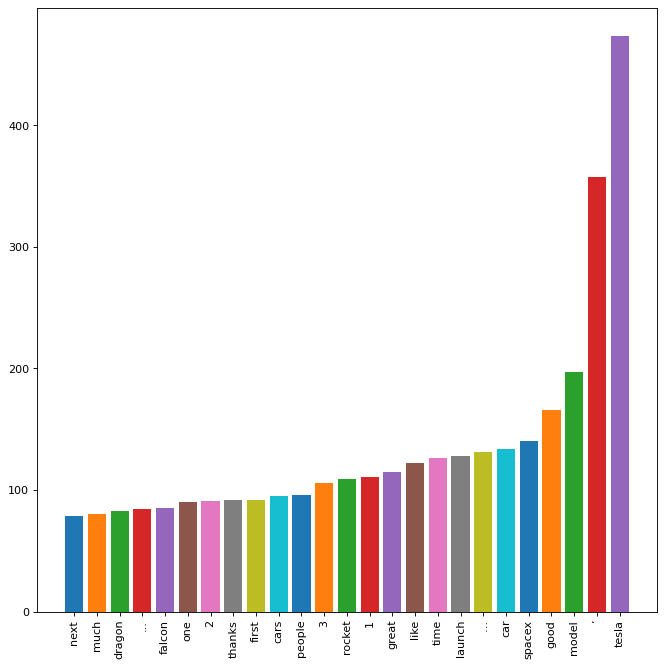

In [21]:
plt.figure(figsize=(10,10), dpi= 80)
lables = []
for i, w in enumerate(kw_dist_top_sorted):
    plt.bar(x = i,height= kw_dist[w])
plt.xticks(range(n),kw_dist_top_sorted.keys(), rotation = 'vertical')
plt.show()

In gewisser Weise sind diese Ergebnisse dann doch überraschen, denn es ist nicht zu erwarten gewesen, dass Musk 'Tesla' und 'model' (von Model S oder Model 3, Modellbezeichungen der Tesla-Fahrzeuge) mehr als doppelt so oft vorkommen, wie die nächsten Top Wörter. Sonst wird sehr oft Launch, also SpaceX Launches erwähnt und allgemein viel über 'cars' getwittert, was aber zu erwarten ist.

## Erstellung der Datensätze und Entwicklung des Modells

Zur Generierung von Text gibt es viele Möglichkeiten. Die klassische Methode sind Markov-Ketten, in denen immer das nächste Wort auf Basis des vorherigen Wortes vorhergesagt wird. Der moderne Ansatz sind auf neuronalen Netzen aufbauende Modelle. Einfache Perceptrons bieten aber nur wenige bis keine Möglichkeiten zusammenhängende Sätze zu verarbeiten. Stattdessen wurden Architekturen wie Recurrent Neural Networks entwickelt, in denen Neuronen auch mit Ausgaben folgender Neuronen gefüttert werden. Das LSTM speichert Eingaben vorheriger Eingaben und kann so mit sequentiellen Daten arbeiten. Der heutige Standard sind aber sogenannte Transformer. Ihre Grundlage ist der Attention-Mechanismus. Attention beruht auf Lookup-Tabellen, die im Netzwerk anlernbar sind. Beim Vorhersagen eines Elements in einer Sequenz kann also auch gelernt werden, welche Elemente davor und danach vorkommen. Das Training ist dafür sehr aufwändigt und benätigt einen sehr großen Korpus. Ein Modell, das mit einem solchen Korpus trainiert wurde ist GPT2. Der Korpus besteht aus den Texten von 8 Millionen Websites, auf die von der Internet-Plattform Reddit verlinkt wird. Weil die generierten Texte dadurch sehr gut Texte widerspiegeln, die im Internet zu finden sind, wird GPT-2 sehr oft für die Generierung von Texten, die Sprache im Intenet imitieren sollen genutzt.

In [24]:
gen = pipeline('text-generation', model='gpt2')

In [25]:
gen("Elon Musk is a ")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Elon Musk is a ersatz social conservative. The internet does not represent any individual's political viewpoints. You might call him a fascist or a dictator, but he can't be taken into account by anyone. It is impossible to know if he"}]

In diesem Modell ist aber die Sprache von Elon Musk nicht gut repräsentiert. Um das zu verbessern wird auf Transfer-Learning zurückgegriffen. Beim Transfer Learning wird statt ein neues Modell zu trainieren ein existierendes Modell wie GPT-2 mit den spezifischen Daten trainiert. Die Bibliothek `transformers` bietet dafür eine Reihe von existierienden Modellen, darunter auch GTP-2 an.
Sprachemodelle können nicht mit den Rohen sprachdaten trainiert werden. Sie werden mit einer aneinanderreihung von Tokens, also numerischen Werten, die die einzelnen Wörter repräsentieren trainiert. GPT-2 bietet bereits einen passenden Tokenizer, der auf Texte mit Elon Musks Tweets angepasst werden muss. Weil das Modell immer ein Prompt braucht im Text zu generieren, wird ein `BOS_TOKEN` hinzugefügt, der als Prompt auch im Training vor jedem Tweet eingefügt wird. So lernt das Modell, dass jedem Prompt, ein Tweet von Elon Musk folgt. Es gibt auch einen End of Sequence Token, damit soll unter anderem gelernt werden, keine zu langen Texte zu generieren. In der Praxis funktioniert dies aber nur bedingt zuverlässig. Der `IMAGE_TOKEN` und der `LINK_TOKEN` sollen dafür sorgen, dass diese Teile des textes nicht aus anderne Tokens zusammengesetzt werden sondern immer am Stück vorhergesagt werden.

In [22]:
BOS_TOKEN = "<|elontext|>"
EOS_TOKEN = "<|endoftext|>"
PAD_TOKEN = "<|pad|>"
IMAGE_TOKEN = "<image>"
LINK_TOKEN = "<link>"
MAX_TOKENS = 256

In [23]:

tokenizer = AutoTokenizer.from_pretrained("gpt2",
    bos_token=BOS_TOKEN,
    eos_token=EOS_TOKEN,
    pad_token=PAD_TOKEN,
    max_length=MAX_TOKENS,
    is_split_into_words=True,
)
tokenizer.add_tokens([LINK_TOKEN, IMAGE_TOKEN])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


2

Die Tokenizer werden auch gespeichert, damit sie später zur Weiterverwendung verfügbar sind.

In [24]:
#tokenizer.save_pretrained('./musktokenizer')

Neben GPT-2 wird außerdem noch das Modell 'distil-gpt2' genutzt. Das ist eine kleinere Version von 'GPT-2' und nutzt etwa die Hälfte der Neuronen bzw. Parameter. Beide Modelle sollen verglichen werden.

In [36]:
distil_tokenizer = AutoTokenizer.from_pretrained("distilgpt2",
                                          bos_token=BOS_TOKEN,
                                          eos_token=EOS_TOKEN,
                                          pad_token=PAD_TOKEN,
                                          max_length=MAX_TOKENS,
                                          is_split_into_words=True,
                                          )
distil_tokenizer.add_tokens([LINK_TOKEN, IMAGE_TOKEN])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


2

Um sicher zu gehen, dass mit korrekten Daten gelernt wird, werden die Tokenizer einmal getestet. Dafür wird ein Text encodiert und decodiert. Dann wird geprüft, ob der noch lesbar ist.

In [ ]:
some_tweets = tweets_from_all_years.sample(n=10, random_state=30)
encoded = tokenizer(some_tweets['tweet'].to_list()[0], padding=True, max_length=MAX_TOKENS, pad_to_max_length=True,)
decoded = tokenizer.decode(encoded['input_ids'])
some_tokens=[]
for i in some_tweets['tweet']:
    some_tokens.append(' '.join(i.split(' ')[:5]))


In [ ]:
encoded = tokenizer(some_tweets['tweet'].to_list()[0], padding=True, max_length=MAX_TOKENS, pad_to_max_length=True,)
decoded = tokenizer.decode(encoded['input_ids'])
some_distil_tokens=[]
for i in some_tweets['tweet']:
    some_distil_tokens.append(' '.join(i.split(' ')[:5]))

In [39]:
some_tokens

['Tesla will make some merch',
 '0 to 155mph trap speed',
 'Order at  <link>',
 '5 minutes from launch. Looks',
 'Spacecraft arrives at Port of',
 'Space Station tracking spaceship docking',
 "Hope we're not just the",
 'Truth is a metaphorical concept',
 ' <image>',
 'These are production design, unlike']

Die Erstellung von Datensätzen, die mit Tensorflow und dem Modell kompatibel sind ist eine größere Herausforderung. Dafür wird die `transformers` zugehörige Bibliothek `datasets` verwendet. Außerdem wird ein Train-und Test-Split erstellt. Das Test Split wird zum Hyperparameter-Tuning verwendet.

In [40]:

## Set tweets to subset or to full dataset
#tweet_ds = some_tweets
import datasets
tweet_ds = tweets_from_all_years
# Damit sich der Datensatz nachher sicher in das Tensorflow Datenformat konvertieren lässt muss mit dem Datenset-Format der transformers library erstellt werden
tweets_ds = datasets.Dataset.from_pandas(tweet_ds[['tweet']])

tweets_ds = tweets_ds.train_test_split(test_size=0.2)
MAX_TOKENS = max([len(tokenizer.encode(tweet, add_special_tokens=True)) for tweet in tweet_ds['tweet']])+2
DISTIL_MAX_TOKENS = max([len(distil_tokenizer.encode(tweet, add_special_tokens=True)) for tweet in tweet_ds['tweet']])+2

In [41]:
tweets_ds['train']

Dataset({
    features: ['tweet', '__index_level_0__'],
    num_rows: 3912
})

In [42]:
tweets_ds['test']

Dataset({
    features: ['tweet', '__index_level_0__'],
    num_rows: 978
})

Die `prepare_text` Funktion wird später mit einer `map` Funktion verwendet um die Texte in token-sequenzen umzuwandeln.

In [43]:
## mit anpassungen übernommen aus https://data-dive.com/finetune-german-gpt2-on-tpu-transformers-tensorflow-for-text-generation-of-reviews
def prepare_text(tweets:list, prep_tokenizer, prep_MAX_TOKENS):
    # Einfügen der Prompts vor jeden Tweet
    text = [BOS_TOKEN + tweet + EOS_TOKEN for tweet in tweets['tweet']]

    tokenized = prep_tokenizer(
        text,
        add_special_tokens=True,  # Only adds pad not eos and bos
        max_length=prep_MAX_TOKENS,
        truncation=True,
        pad_to_max_length=True,
    )
    tokenized["labels"] = tokenized["input_ids"].copy()

    return tokenized

In [ ]:
distil_tweets_ds = tweets_ds.map(
    lambda x: prepare_text(x, distil_tokenizer,DISTIL_MAX_TOKENS),
    batched=True,
    #num_proc=4,
    # ursprünglich spalten entfernen
    remove_columns=['tweet','__index_level_0__'],
    load_from_cache_file=True,
)

In [ ]:
tweets_ds = tweets_ds.map(
    lambda x: prepare_text(x, tokenizer, MAX_TOKENS),
    batched=True,
    #num_proc=4,
    remove_columns=['tweet','__index_level_0__'],
    load_from_cache_file=True,
)

Der fertige Text wird zum Test nochmal dekodiert. Nun sind auch Padding Tokens vorhanden, um alle Sequenzen auf die gleiche Länge, und damit in ein für das Modell zu verarbeitende Format zu bringen.

In [38]:

for i in tweets_ds['train']:
    print(tokenizer.decode(i['input_ids']))
    break

<|elontext|>Am getting lots of questions about the big Supercharger announcement. Aiming to do that the week after next.<|endoftext|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|>


Das Datenset muss in das von Tensorflow Datenformat konvertiert werden. Dafür bietet `datasets` eine vorgefertigte Funktion und es muss lediglich eine funktion drum herum geschrieben werden, die das Schema an das Modell anpasst.

DataCollators sind eine Funktion von `datasets` um weitere funktionen zu der Konvertierungs-Pipeline hinzuzufügen. In diesem Fall ist er nur ein Hilfswerkzeug zur generierung der Datensätze

In [46]:
data_collator = DefaultDataCollator(return_tensors="tf")
BATCH_SIZE = 4

In [47]:
train = tweets_ds['train'].to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"],
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
)
test = tweets_ds['test'].to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"],
    shuffle=False,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
)

In [48]:
distil_train = distil_tweets_ds['train'].to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"],
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
)
distil_test = distil_tweets_ds['test'].to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"],
    shuffle=False,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
)

Für das Training werden einige Hyperparameter benötigt, die nicht manuell angepasst werden. Zudem wird der Datensatz in Batches unterteilt, damit Stochastic Gradient verwendet wird.

In [51]:
BUFFER_SIZE = len(train)
DISTIL_BUFFER_SIZE = len(distil_train)

In [52]:
distil_train = distil_train.shuffle(len(distil_train))
train = train.shuffle(len(train))

Die Modelle von `transformers` sind mit Tensorflow kompatibel und lassen sich über die Bibliothek einfach laden

In [ ]:
model = TFGPT2LMHeadModel.from_pretrained(
    "gpt2",
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
)
distil_model = TFGPT2LMHeadModel.from_pretrained(
    "distilgpt2",
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
)

# Weil die anzahl der Standard Tokens im Tokenizer angepasst wurde, müssen auch die Größen der ersten Layer angepasst werden.
model.resize_token_embeddings(len(tokenizer))
distil_model.resize_token_embeddings(len(distil_tokenizer))

Der am meisten genutzte Optimizer ist Adam. Dieser wird auch in GPT-2 und dementprechen duach hier verwendet. Die Parameter sind die, die auch im Grundtraining von Tensorflow verwendet werden.

In [55]:
optimizer = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01)
model.compile(optimizer=optimizer)
model.summary()

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour, please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Model: "tfgpt2lm_head_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFGPT2MainLaye  multiple                 124442880 
 r)                                                              
                                                                 
Total params: 124,442,880
Trainable params: 124,442,880
Non-trainable params: 0
_________________________________________________________________


In [56]:
distil_optimizer = AdamWeightDecay(learning_rate=1e-6, weight_decay_rate=0.01)
distil_model.compile(optimizer=distil_optimizer)
distil_model.summary()

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour, please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Model: "tfgpt2lm_head_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFGPT2MainLaye  multiple                 81915648  
 r)                                                              
                                                                 
Total params: 81,915,648
Trainable params: 81,915,648
Non-trainable params: 0
_________________________________________________________________


Wie zu sehen, hat das `distil_model` deutlich weniger Parameter als das normale Modell. In diesem Fall sind es aber nicht wie angegeben die Häflte sondern etwas mehr.

Mit der `fit` Funktion wird das Training gestartet. Bei GPT-2 dauert es etwa 1-2h auf einem MacBook Pro mit Intel Core i9 ohne GPU Beschleunigung. Mit der Hardware Beschleunigung einer GTX 1070 lässt sich diese Zeit auf wenige Minuten kürzen.

In [84]:
model_hist = model.fit(
    train.repeat(),
    epochs=6,
    steps_per_epoch=BUFFER_SIZE / BATCH_SIZE,
)

Epoch 1/6
244/244 [==============================] - 66s 203ms/step - loss: 2.3092
Epoch 2/6
244/244 [==============================] - 49s 202ms/step - loss: 1.2153
Epoch 3/6
244/244 [==============================] - 49s 200ms/step - loss: 1.0298
Epoch 4/6
244/244 [==============================] - 49s 202ms/step - loss: 1.0258
Epoch 5/6
244/244 [==============================] - 49s 201ms/step - loss: 0.9704
Epoch 6/6
244/244 [==============================] - 49s 200ms/step - loss: 0.9624


Das Modell lässt sich speichern, die Funktion sind aber auskommentiert, damit nicht aus versehen ein exisiterendes Modell überschrieben wird.

In [85]:
#model.save_pretrained("./MUSK_GPT_UNOPTIMIZED")

Das Training von GPT-2 dauert mit dem MacBook unter 15 Minuten.

In [75]:
distil_train

<PrefetchDataset element_spec={'labels': TensorSpec(shape=(4, None), dtype=tf.int64, name=None), 'input_ids': TensorSpec(shape=(4, None), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(4, None), dtype=tf.int64, name=None)}>

In [76]:
distil_model_hist = distil_model.fit(
    distil_train.repeat(),
    epochs=6,
    steps_per_epoch= DISTIL_BUFFER_SIZE / BATCH_SIZE,
    validation_data=distil_test,
)

Epoch 1/6
244/244 [==============================] - 39s 161ms/step - loss: 1.8267 - val_loss: 1.7123
Epoch 2/6
244/244 [==============================] - 39s 159ms/step - loss: 1.7179 - val_loss: 1.5952
Epoch 3/6
244/244 [==============================] - 39s 159ms/step - loss: 1.5829 - val_loss: 1.5181
Epoch 4/6
244/244 [==============================] - 39s 159ms/step - loss: 1.5108 - val_loss: 1.4564
Epoch 5/6
244/244 [==============================] - 40s 162ms/step - loss: 1.4772 - val_loss: 1.3998
Epoch 6/6
244/244 [==============================] - 39s 160ms/step - loss: 1.4880 - val_loss: 1.3570


In [77]:
#distil_model.save_pretrained("./MUSK_DISTIL_GPT_UNOPTIMIZED")

## Hyperparameter Optimierung
Hyperparameter Optimierung hat bei generativen Sprachemodellen nur einen geringen Einfluss. Ein Modell ist aufgrund schlechterer Metriken, in der Wahrnehmung eines Menschen zwangsläufig schlechter. Im Voraus lässt sich dazu allerdings kein Beurteilung machen. Sie wird aber trotzdem durchgeführt, weil sie für Machine Learning im allgemeinen obligatorisch ist. In diesem Fall wird das Framework KerasTrainer verwendet. Die Parameter die optimiert werden sollen sind die Batch Size, die Learning Rate, der Weight Decay und die anzahl der Epochen. Aufgrund des hohen Zeitaufwandes und des hohen Energieverbrauchs des Hyperparametertunings, gibt es nur einen sehr eng begrenzten Suchbereich. Dieser wird auch nicht erweitert, wenn die optimalen Werte ganz außen sind.

In [57]:
import keras_tuner as kt

In [58]:
#tunable parameters
batch_size=16
lr=2e-5
num_train_epochs=5

In [59]:
#https://wandb.ai/amogkam/transformers/reports/Hyperparameter-Optimization-for-Huggingface-Transformers--VmlldzoyMTc2ODI
class Musk_Model(kt.HyperModel):

    def __init__(self, huggingface_model='gpt2', name=None, tunable=True):
        self.huggingface_model = huggingface_model
        super().__init__(name, tunable)

    def build(self, hp: kt.HyperParameters):
        self.BATCH_SIZE = hp.Choice('batch_size',[4,8,16,32])
        model = TFGPT2LMHeadModel.from_pretrained(
            self.huggingface_model,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            bos_token_id=tokenizer.bos_token_id,
        )
        model.resize_token_embeddings(len(tokenizer))
        optimizer = AdamWeightDecay(learning_rate=hp.Choice('learning_rate', [2e-5, 3e-5, 5e-5, 7e-5]), weight_decay_rate=hp.Choice('weight_decay_rate',[0.0,0.01, 0.001,0.1]))
        model.compile(optimizer=optimizer)
        return model
    def fit(self, hp: kt.HyperParameters, model, *args, **kwargs):
        return model.fit(
            train.repeat(),
            batch_size= self.BATCH_SIZE,
            epochs=hp.Int('epochs',min_value=2, max_value=8),
            steps_per_epoch=BUFFER_SIZE / self.BATCH_SIZE,
            validation_data=test,
        )


Als Optimierungsalgorithmus wird Bayesche Optimierung genutzt. Dies ist eine gute Balance zwischen Zeitaufwand, Entwicklungsaufwand und Qualität der Ergebnisse. Mit `val_loss` als objective wird der Validierungsdatensatz als Zielwert verwendet.

In [107]:
tuner = kt.BayesianOptimization(
    hypermodel=Musk_Model(),
    objective="val_loss",
    max_trials=8,
    overwrite=True,
    directory="hyper-opt/",
    project_name="tune_tweet_generation",
)
tuner.search_space_summary()

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour, please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Search space summary
Default search space size: 3
batch_size (Choice)
{'default': 4, 'conditions': [], 'values': [4, 8, 16, 32], 'ordered': True}
learning_rate (Choice)
{'default': 2e-05, 'conditions': [], 'values': [2e-05, 3e-05, 5e-05, 7e-05], 'ordered': True}
weight_decay_rate (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.01, 0.001, 0.1], 'ordered': True}


In [73]:
tuner.search()
best_hp: kt.engine.hyperparameters.HyperParameters = tuner.get_best_hyperparameters()[0]
best_hp.values

Trial 8 Complete [00h 04m 20s]
val_loss: 0.9074983596801758

Best val_loss So Far: 0.8868565559387207
Total elapsed time: 00h 44m 09s
INFO:tensorflow:Oracle triggered exit


In [ ]:
hyper_model = Musk_Model()
optimized_model = hyper_model.build(best_hp)
optimized_hist = hyper_model.fit(best_hp,optimized_model)

In [78]:
#optimized_model.save_pretrained("./MUSK_GPT_OPTIMIZED")

Hier lässt sich der Loss über den Zeitraum aller Iterationen beim optimiertenModell betrachten. Der Validierungs-Datensatz wird dabei immer nur ein Wenig besser, während das Modell im Trainingsdatensatz schnell besser und am Ende ein wenig schlechter wird.

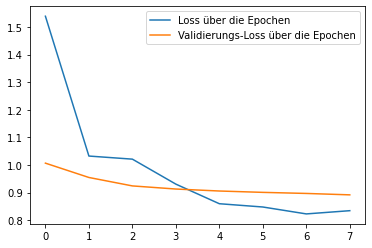

In [82]:
plt.plot(optimized_hist.history['loss'], label="Loss über die Epochen")
plt.plot(optimized_hist.history['val_loss'], label="Validierungs-Loss über die Epochen")
plt.legend()
plt.show()

Auch das Tuning der Hyperparameter wird mit "distilgpt2" wiederholt. Die benötigte Zeit ist hiet deutlich geringer. Zur Vergleichbarkeit werden aber auch hier die gleichen Strategien angewendet.

In [ ]:
distil_tuner = kt.BayesianOptimization(
    hypermodel=Musk_Model(huggingface_model='distilgpt2'),
    objective="val_loss",
    max_trials=8,
    overwrite=True,
    directory="hyper-opt/",
    project_name="tune_distil_tweet_generation",
)

In [61]:
distil_tuner.search()

Trial 8 Complete [00h 02m 30s]
val_loss: 0.9383436441421509

Best val_loss So Far: 0.9278596639633179
Total elapsed time: 00h 28m 35s
INFO:tensorflow:Oracle triggered exit


In [62]:
best_d_hp: kt.engine.hyperparameters.HyperParameters = distil_tuner.get_best_hyperparameters()[0]
best_d_hp.values

{'batch_size': 4,
 'learning_rate': 7e-05,
 'weight_decay_rate': 0.1,
 'epochs': 8}

In [65]:
distil_hyper_model = Musk_Model()
optimized_distil_model = distil_hyper_model.build(best_d_hp)
optimized_distil_hist = distil_hyper_model.fit(best_d_hp,optimized_distil_model)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour, please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Epoch 1/8
244/244 [==============================] - 79s 261ms/step - loss: 1.7410 - val_loss: 1.0410
Epoch 2/8
244/244 [==============================] - 61s 251ms/step - loss: 1.0790 - val_loss: 0.9673
Epoch 3/8
244/244 [==============================] - 61s 251ms/step - loss: 0.9805 - val_loss: 0.9487
Epoch 4/8
244/244 [==============================] - 62s 253ms/step - loss: 0.9648 - val_loss: 0.9196
Epoch 5/8
244/244 [==============================] - 61s 251ms/step - loss: 0.8874 - val_loss: 0.9142
Epoch 6/8
244/244 [==============================] - 61s 251ms/step - loss: 0.8540 - val_loss: 0.9032
Epoch 7/8
244/244 [==============================] - 61s 251ms/step - loss: 0.8446 - val_loss: 0.8976
Epoch 8/8
244/244 [==============================] - 61s 251ms/step - loss: 0.8460 - val_loss: 0.8940


Beide Modelle erreichen letztendlich einen ähnlichen Validation loss, dies sagt aber wenig über die allgemeine Qualität des Modells aus.

In [66]:
#optimized_distil_model.save_pretrained('./MUSK_DISTIL_GPT_OPTIMIZED')

## Modelle laden und Inferencing

Die Modelle können nun geladen werden und Ergebnisse produziert werden

In [68]:
model = TFGPT2LMHeadModel.from_pretrained("./MUSK_GPT_OPTIMIZED")
distil_model = TFGPT2LMHeadModel.from_pretrained("./MUSK_DISTIL_GPT_UNOPTIMIZED")
optimized_model = TFGPT2LMHeadModel.from_pretrained("./MUSK_GPT_OPTIMIZED")
optimized_distil_model = TFGPT2LMHeadModel.from_pretrained("./MUSK_DISTIL_GPT_OPTIMIZED")

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at ./MUSK_GPT_OPTIMIZED.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at ./MUSK_DISTIL_GPT_UNOPTIMIZED.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at ./MUSK_GPT_OPTIMIZED.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictio

In [103]:
BOS_TOKEN = "<|elontext|>"
default_gen = pipeline("text-generation", model='gpt2')
gen = pipeline("text-generation", model=model, tokenizer=tokenizer)
distil_gen= pipeline('text-generation', model=distil_model, tokenizer=distil_tokenizer)
opt_gen = pipeline('text-generation', model=optimized_model, tokenizer=tokenizer)
opt_distil_gen = pipeline('text-generation', model=optimized_distil_model, tokenizer=distil_tokenizer)

## Modell Evaluierung
Mit den zuvor festgelegt Prompt lässt sich nun Text generieren. Die Texte von GPT-2 sind zwar manchmal etwas verwirrend und ergeben inhaltlich keinen besonderen Sinn, sind aber grammatikalisch meißt korrekt und passen auch zu Elon Musks sonstigen Tweets.

In [104]:
#default model
default_gen(BOS_TOKEN)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': '<|elontext|>\n\n<|b| | | a| |.\n\n:a b|\n\n.:c\n\n.||.\n\n|:m b|\n\n.|c\n\n'}]

In [ ]:
#default model mit tweet prompt

In [76]:
# trainiertes modell
gen(BOS_TOKEN)

[{'generated_text': '<|elontext|>@jones3 @Gatorade No problem'}]

In [ ]:
#trainiertes modell mit tweet prompt

In [73]:
#trainiertes modell mit hyperparameter tuning
opt_gen(BOS_TOKEN)

[{'generated_text': '<|elontext|>@IDGAA That would be worth a lot of money.'}]

Das Distil-GPT-2 Modell ist im Gegensatz dazu eher unbrauchbar. Die Texte ergeben keinen Sinn und haben keinen Zusammenhang. Das zeigt sich vor allem auch darin, dass die Texte grammatikalische starke Schwächen haben, was bei GPT2 nicht der Fall ist.
 Dieser qualitative Unterschied bestätigt, dass der Loss kein besonders guter Indikator für die Qualität des Modells.

In [74]:
#trainiertes distilgpt2 modell mit hyperparamerter tuning
distil_gen(BOS_TOKEN)

[{'generated_text': '<|elontext|> is a personal injury, and is a with a non-cabin in the trunk, and is a one-piece container.'}]

Das wird mit dem optimierten Modell ein wenig besser, allerdings gibt es auch hier keinen wirklichen Zusammenhang.

In [80]:
#trainiertes distilgpt2 modell mit hyperparamerter tuning mit tweet prompt
opt_distil_gen(BOS_TOKEN)

[{'generated_text': "<|elontext|>First time making a Model 3.0. Autopilot is great. Hopefully by then we're all fine."}]

Stattdessen ist eine Evaluierung interessant, in der getestet wird, ob eine Gruppe aus Studierenden der Wirtschaftsinformatik die generierten Tweets von den echten Tweets unterscheiden können.
Für diese Evaluierung wurden zufällig Paare aus echten Tweets und und falschen Tweets erstellt. Den Studierenden wurde der Auftrag gegeben, den echten Tweet von beiden zu bestimmen und dafür auf einer Website abzustimmen.  Die Ergebnisse wurden in einer Datenbank gespeichert. Das genutzte Modell ist dafür das erste GPT-2 Modell ohne Hyperparameter Tuning, weil dieses zu dem Zeitpunk noch nicht fertig war.

Einige Beispielpaare sind:


Generierter Tweet "The only way to reach me is to tweet @barned_slaming “@chris_nho"
Echter Tweet: "Which leads me to my next subject of gun control ... just kidding"

Generierter Tweet: "️ Thanks for a great AMA!","real":
Echter Tweet: "1st firing of Falcon 9-R advanced prototype rocket. Over 1M lbs thrust, enough to lift skyscraper  http://t.co/AUCsWTw77E"

Generierter Tweet: "I'd love to make a nice big rock on ice! Maybe some great ice cream!"
Echter Tweet:"@MaxMBerger The collective wisdom of the market is usually (not always) better than the smartest govt regulator."

Bei der Abstimmung konnte GPT-2 zwar in weniger Fällen täuschen, dies ist aber zu erwarten, weil GPT-2 natürlich kein echter Mensch ist sondern noch immer ein Sprachmodell, das nur Sprache aber keine Inhalte versteht. Trotzdem ist die Anzahl der als falsch als echt benannten Tweets betrachtlich und Zeigt auch, dass es nicht unmöglich ist Menschen zu täuschen.

## Auswahl eines Modells für eine Evaluierung mit Testsubjekten
Mit einer Gruppe Studierender soll evaluiert werden ob es mit dem Modell möglich ist tweets zu generieren, die von echten Tweets nicht zu unterscheiden sind, dafür soll eines der Modelle ausgewählt werden.
Weil zum Zeitpunkt des Test noch die Hyperparameter Optimierung lief, wurde das erste Modell verwendet. Dieses ist allerdings asugereift genug, um Tweets zu generieren.
Die Gruppe Studierender öffnet eine Website, auf der immer jeweils 2 Tweets präsentiert werden. Die Studierenden sollen auswählen, von welchem beider Tweets sie glauben, dass er echt. Es existiert die Möglichkeit, dass die Tweets auch live generiert werden. Das genutzte Modell generiert allerdings gelegntlich Tweets die leer sind oder vollständig sinnlos sind. Diese automatisch herauszufiltern wäre ein großer Aufwand gewesen. Aus diesem Grund werden für das Experiment Tweets vorher generiert und auf 65 Tweets gekürzt, die syntaktisch Sinn ergeben. Diese wurden dann einem echten Tweet zugeordnert und als Paar in der Datenbank gespeichert, damit sie miteinander vergleichbar sind.

Insgesamt wurde 78 Mal geraten, es gab also auch Tweets, die doppelt verwendet wurden. Dabei wurde 34 Mal der Falsche und 44 Mal der richtige Tweet ausgewählt. Ein optimales Ergebnis wäre 39 zu 39 gewesen

![Statistik Raten](experiment.png)


Dieses Ergebnis lässt sich aus zwei Perspektiven betrachten. Aus der Sicht, dass es sich um ein Modell handelt dass menschliche Sprache imitieren soll, sind die Ergebnisse relativ gut, weil es sich dabei um eine komplizierte Aufgabe handelt. Aus der Sicht, dass den 'Probanden' aber nur ein kurzer Text gegeben wird, anhand dessen die Echtheit allgemein schlecht zu unterscheiden ist, wäre ein Ergebniss näher am Optimimum wünschenswert gewesen.

Einige Beispiele für generierte Tweets, die für echte Tweets gehalten wurden:

Echt:"My first prediction of 2012 has come true: ouch, my head hurts.

Falsch: " @JLobuchan @Yahoo! Will do a live demo at the Air Force Museum tonight at 3pm, where all 50 astronauts will have the opportunity to speak. Thanks to everyone!"



Echt:"No kidding"

Falsch:"I'm a proud Canadian proud of the incredible work of @Yahoo! I hope you guys can find a cure for cancer.  link"



Echt: "My @SpaceX team is not working for  link link"

Falsch: "Tesla articles 30 mins apart: "This Stock is Screaming Buy"  link and "This Stock Could Get DESTROYED"  link"

## Fazit und Ausblick
In dieser Arbeit lies sich zeigen, dass State-of-the-Art Machine Learning Modelle dazu genutzt werden können kurze Texte zu generieren, mit denen sich Menschen in ein paar Fällen überzeugen lassen sie seien echt. Das zeigt auch, dass kurze Texte mit wenige großem Zusammenhang sehr einfach zu generieren sind
 Allerdings lassen sich noch viele Verbeserung auf dieses Modell anwenden. Es existieren noch viele andere Sprache-Modelle, die nicht verglichen wurden. Zudem gibt es verschiedene Arten, den Trainings-Datensatz zu struktuieren, was auch Einfluss auf das spätere Modell hat. Ein weiteres interessantes Experiment ist die Generierung von Antworten auf andere Tweets anhand bisheriger Antworten. Ein interessantes Experiment wäre es, mit dem Modell einen Bot zu entwickeln, der einen Twitter-Account als Elon Musk betreibt. Dies ist auch der einzige tatsächliche Use-Case, der für diese Art von Modell vorstellbar ist. Generell ist das weniger als ein sinnvolles Projekt zu sehen, sondern als eine Art Benchmark, in dem zu sehen ist, was mit heutigen Modell möglich ist. In diesem Fal hat sich gezeigt, dass Sprachmodelle zu sehr viel fähig sind, weshalb es viele Einsatzfelder für sie gibt.